In [21]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import FlagserPersistence
from gtda.diagrams import BettiCurve
import matplotlib.pyplot as plt
import gudhi as gd
from gtda.plotting import plot_diagram

import glob

In [22]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    counts = [pass_info["count"] for player in game for pass_info in player["passes"]]
    max_count = max(counts)
    min_count = min(counts)

    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))

    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]

            edge_weight = 1 - (count - min_count) / (max_count - min_count)

            # round to 3 decimal places
            edge_weight = round(edge_weight, 3)

            G.add_edge(player1, player2, weight=edge_weight)

    return G


def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

def getAUC(game):
    current_game = load_game_data(game)
    G_example = construct_adjacency_matrix(current_game)

    fp = FlagserPersistence()
    adj_matrix, nodes = graph_to_adjacency_matrix(G_example)

    diagrams = fp.fit_transform([adj_matrix])[0]
    betti_transformer = BettiCurve(
        n_bins=100
    )

    betti_transformer = BettiCurve(n_bins=1000)
    betti_numbers = betti_transformer.fit_transform([diagrams])[0]

    filtration_values = np.linspace(0, 1, num=1000)

    betti0 = betti_numbers[0, :]
    betti1 = betti_numbers[1, :] if betti_numbers.shape[0] > 1 else None


    auc_betti0 = np.trapz(betti0, filtration_values)
    auc_betti1 = np.trapz(betti1, filtration_values) if betti1 is not None else 0

    return auc_betti0, auc_betti1


/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/Users/samborremans/Documents/Dev/TDA/venv310/lib/python3.10/site-packages/numpy/core/function_base.py:160: Runtime

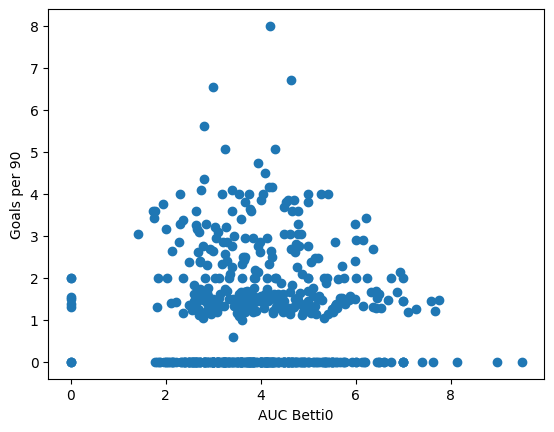

Correlation Betti0: -0.018348404267773868
Correlation Betti1: -0.06396269514038863


In [23]:
directory_path = '../data/2015-2016/1-Bundesliga/*.json'

auc_values = {}

for file_path in glob.glob(directory_path):
    filename = os.path.basename(file_path)
    filename_list = filename.split('_')
    goals = int(filename_list[-2])
    minutes = int(filename_list[-1].split('.')[0])

    goal_per_90 = goals / (minutes / 90)

    auc_betti0, auc_betti1 = getAUC(file_path)
    auc_values[filename] = (auc_betti0, auc_betti1, goal_per_90)

auc_values_list = list(auc_values.values())
auc_values_list = np.array(auc_values_list)
plt.scatter(auc_values_list[:, 1], auc_values_list[:, 2])
plt.xlabel("AUC Betti0")
plt.ylabel("Goals per 90")
plt.show()

correlation_betti0 = np.corrcoef(auc_values_list[:, 1], auc_values_list[:, 2])[0, 1]
correlation_betti1 = np.corrcoef(auc_values_list[:, 0], auc_values_list[:, 2])[0, 1]

print(f"Correlation Betti0: {correlation_betti0}")
print(f"Correlation Betti1: {correlation_betti1}")

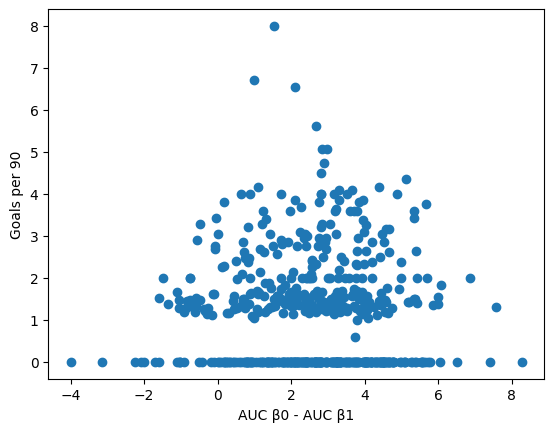

Correlation difference: -0.02233150391746788


In [24]:
# look at the difference between the two AUC values and plot it against the goals per 90
auc_diff = auc_values_list[:, 0] - auc_values_list[:, 1]
plt.scatter(auc_diff, auc_values_list[:, 2])
plt.xlabel("AUC β0 - AUC β1")
plt.ylabel("Goals per 90")
plt.show()
correlation_difference = np.corrcoef(auc_diff, auc_values_list[:, 2])[0, 1]
print(f"Correlation difference: {correlation_difference}")